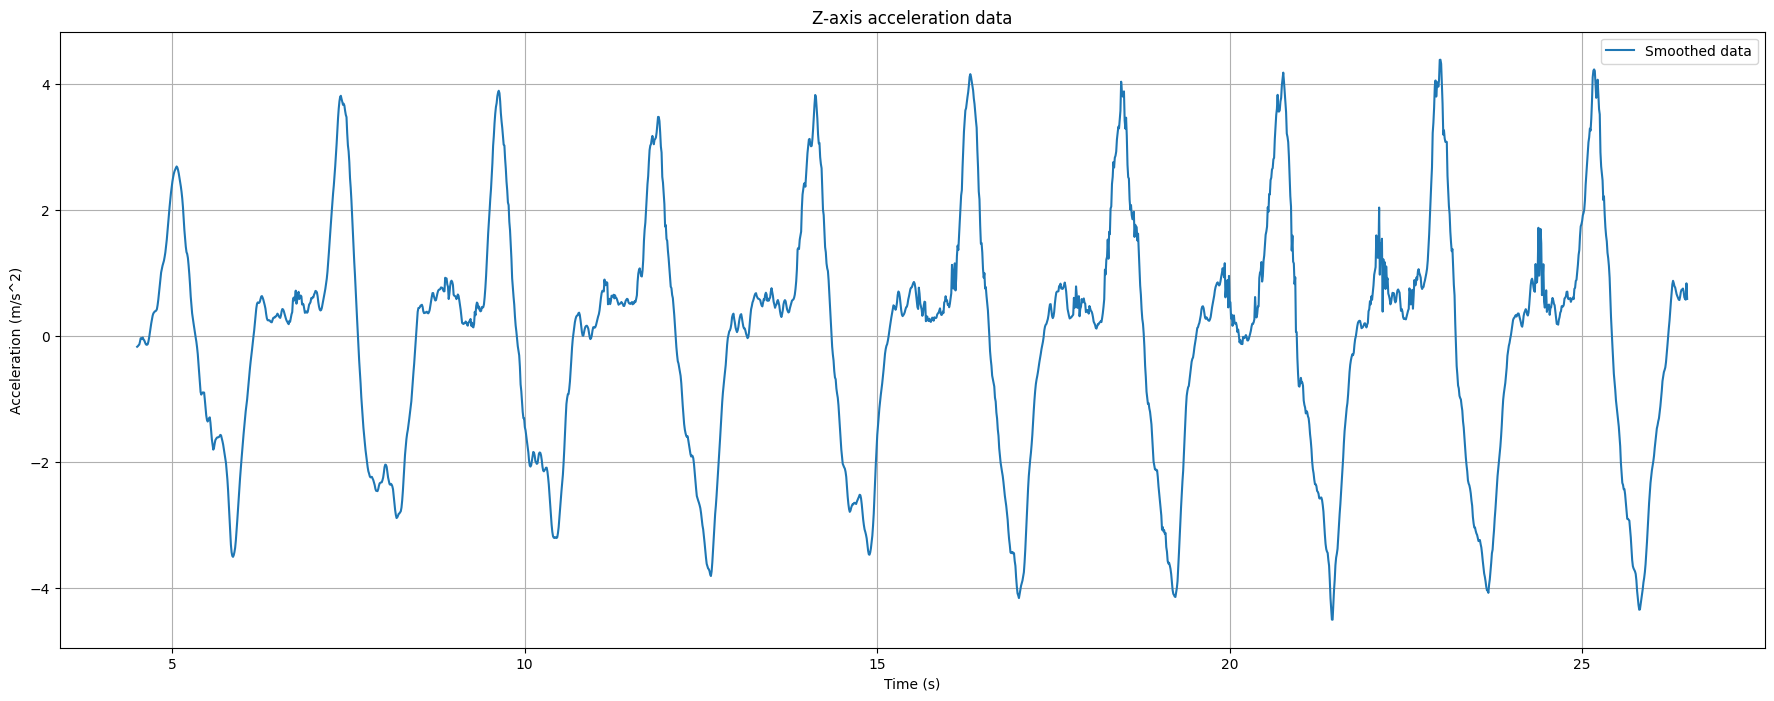

In [3]:
import matplotlib.pyplot as plt
import pandas

# Load the data
df = pandas.read_csv('data/Acceleration without g 2024-03-17 19-47-45/Raw Data.csv')

# Plot the raw z-axis acceleration data
plt.figure(figsize=(22, 8))

# Apply a smoothing filter to the z-axis acceleration data
df['Smoothed Acceleration z (m/s^2)'] = df['Linear Acceleration z (m/s^2)'].rolling(window=5).mean()

starting_time = 4.5
df = df[df['Time (s)'] >= starting_time]
df = df[df['Time (s)'] <= 26.5]

plt.plot(df['Time (s)'], df['Smoothed Acceleration z (m/s^2)'], label='Smoothed data')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Z-axis acceleration data')
plt.legend()
plt.grid()

In [25]:
def get_velocity(acceleration: float, V0: float, delta_t: float):
  # a = (V1-V0) / t
  # V1 = a*t + V0
  return acceleration * delta_t + V0

def get_distance(delta_V: float, delta_t: float):
  # V = s/t
  # s = V*t
  return delta_V * delta_t

def get_energy_spent(mass: float, distance: float, acceleration: float):
  # A = F*s
  # F = m*a
  # A = m*a*s
  return mass * (acceleration + 9.81) * distance

def joules_to_kcal(joules: float):
  return joules / 4184

mass = 50
previous_time = starting_time
previous_velocity = 0.0
total_distance = 0.0
total_energy = 0.0
velocity_vec = [[]]
distance_vec = [[]]
energy_vec = [[]]

for index, row in df.iterrows():
  timestep = row["Time (s)"] - previous_time

  velocity = get_velocity(row["Smoothed Acceleration z (m/s^2)"], previous_velocity, timestep)
  velocity_vec.append([row["Time (s)"], velocity])

  distance_step = get_distance(velocity, timestep)
  total_distance += distance_step
  distance_vec.append([row["Time (s)"], total_distance])

  energy_step = get_energy_spent(mass, distance_step, row["Smoothed Acceleration z (m/s^2)"])
  total_energy += abs(energy_step)
  energy_vec.append([row["Time (s)"], total_energy])

  previous_velocity = velocity
  previous_time = row["Time (s)"]

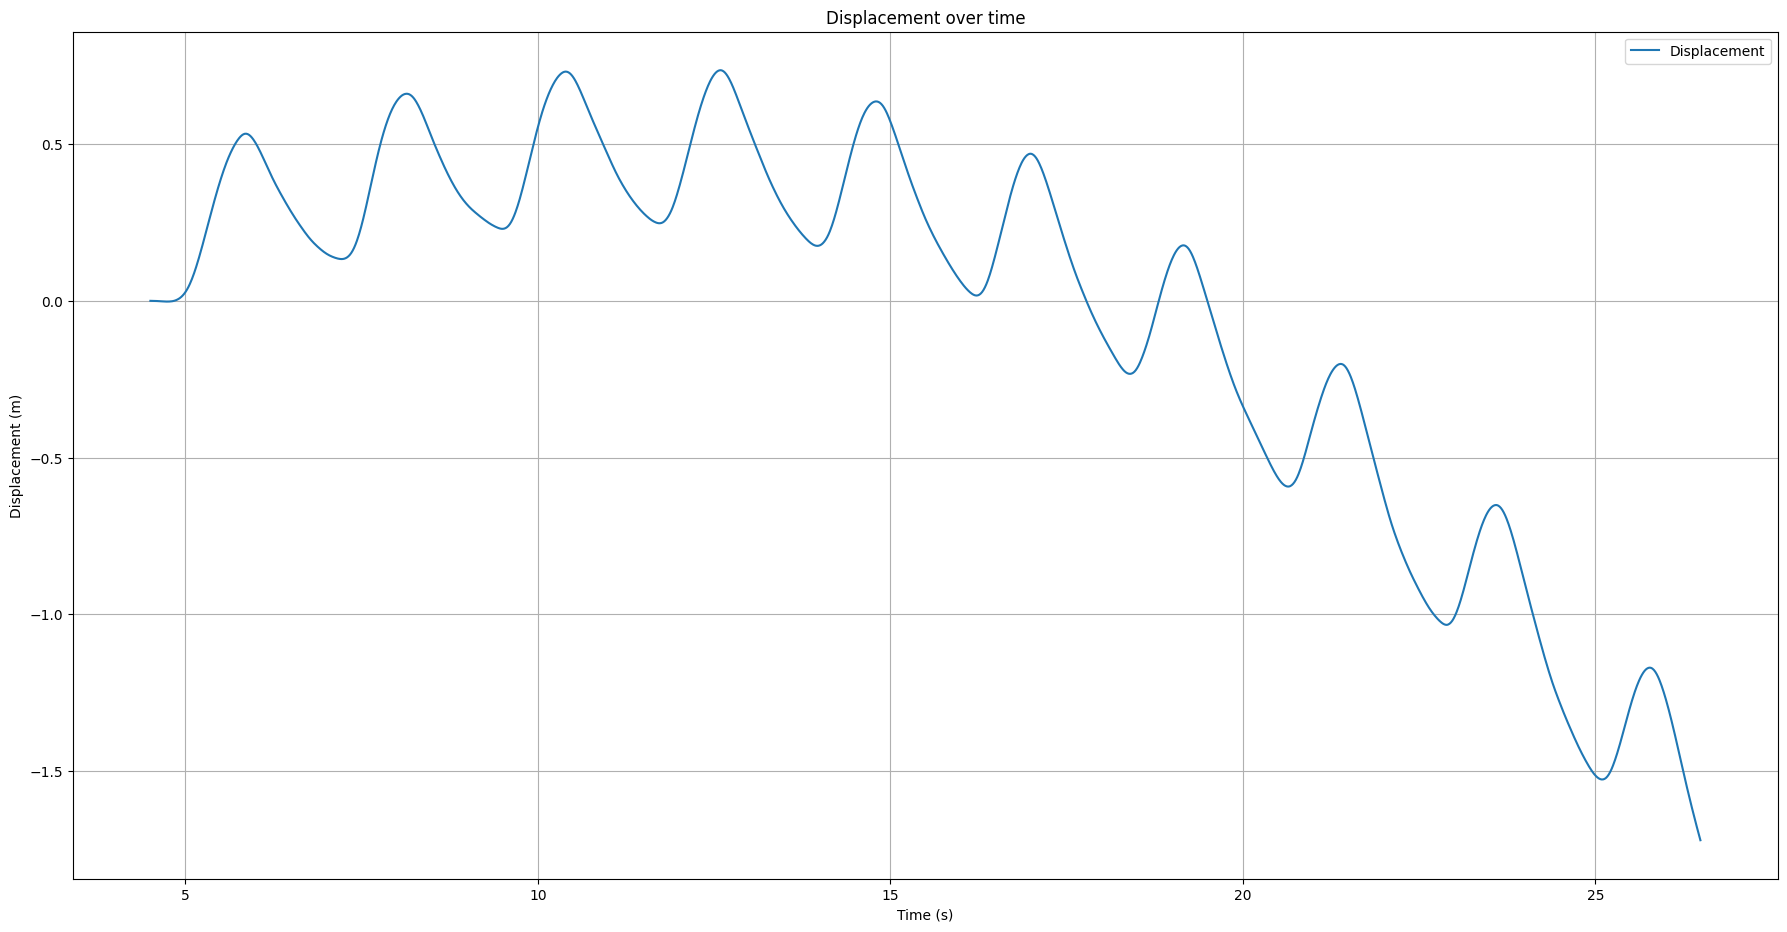

In [12]:
# Convert distance_vec to a pandas DataFrame for easier plotting
distance_df = pandas.DataFrame(distance_vec, columns=['Time (s)', 'Displacement (m)'])

# Plot the displacement data
plt.figure(figsize=(22, 11))
plt.plot(distance_df['Time (s)'], distance_df['Displacement (m)'], label='Displacement')

plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement over time')
plt.legend()
plt.grid()
plt.show()

In [6]:
def get_upward_motion_indices(displacement_data):
  start_indices = []
  end_indices = []
  for i in range(1, len(displacement_data) - 1):
    if displacement_data[i-1] < displacement_data[i] and displacement_data[i] >= displacement_data[i+1]:
      end_indices.append(i)
    if displacement_data[i-1] >= displacement_data[i] and displacement_data[i] < displacement_data[i+1]:
      start_indices.append(i)
  return start_indices, end_indices

/tmp/ipykernel_9649/2680754422.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


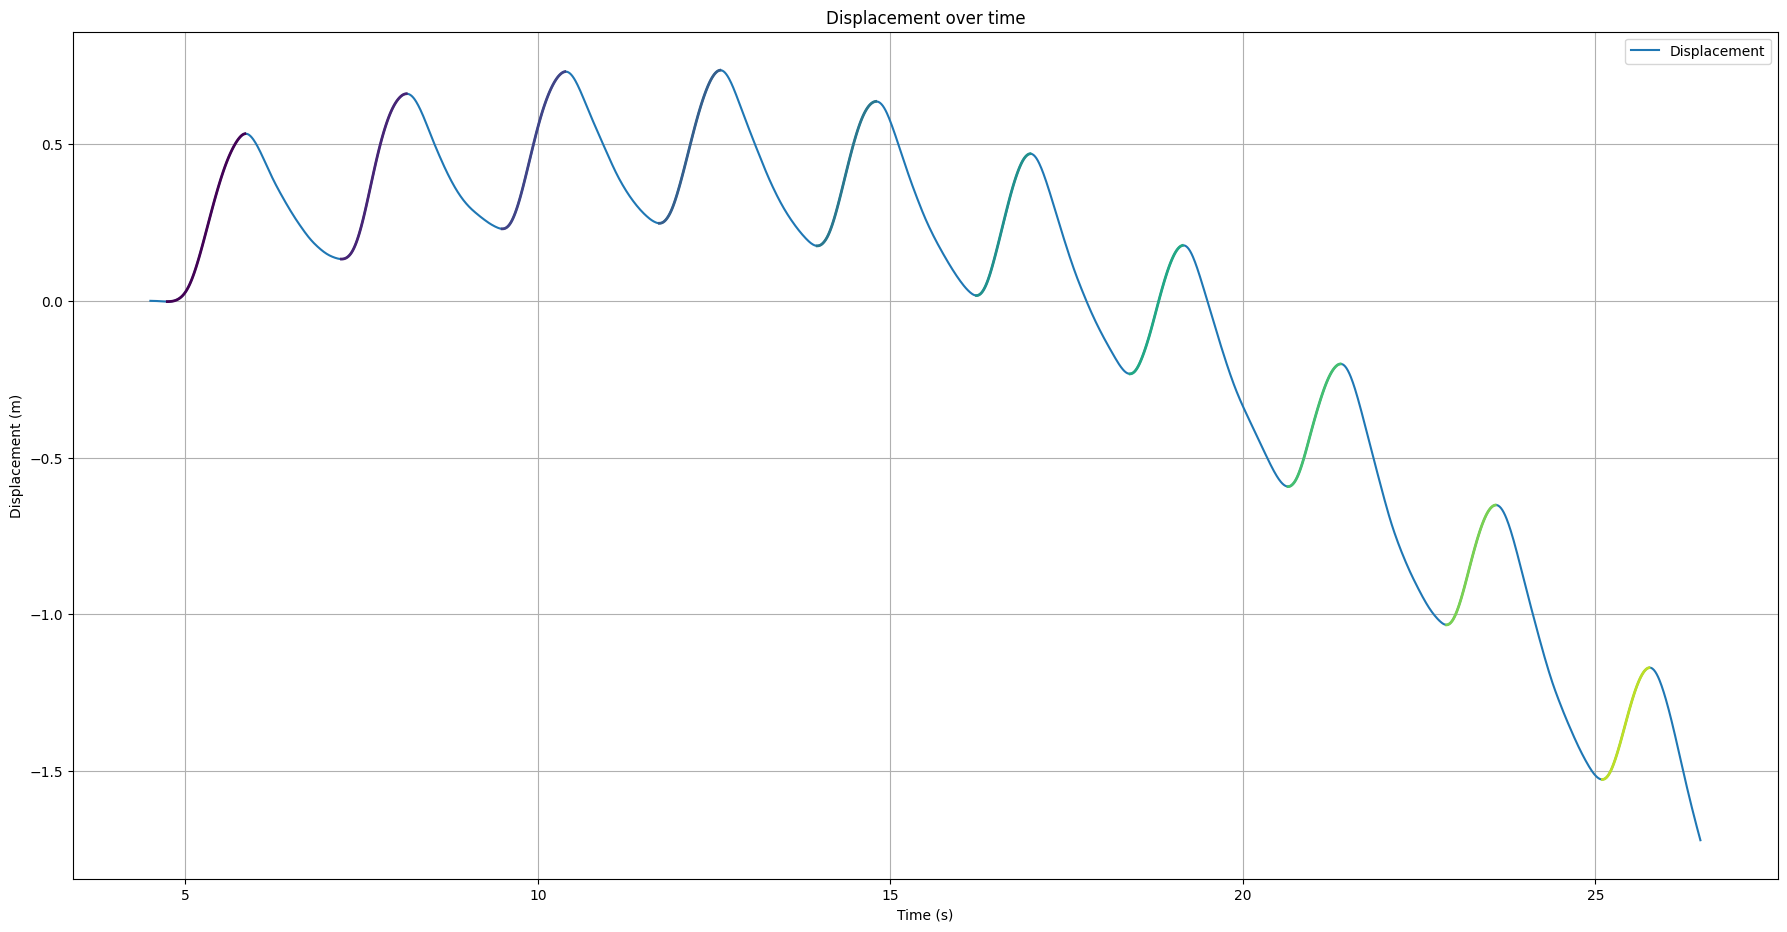

In [13]:
import matplotlib.cm as cm

cmap = cm.get_cmap('viridis')
start_indices, end_indices = get_upward_motion_indices(distance_df['Displacement (m)'].values)
plt.figure(figsize=(22, 11))
plt.plot(distance_df['Time (s)'], distance_df['Displacement (m)'], label='Displacement')

for i in range(len(start_indices)):
  color = cmap(i / len(start_indices))
  plt.plot(distance_df['Time (s)'][start_indices[i]:end_indices[i]], distance_df['Displacement (m)'][start_indices[i]:end_indices[i]], color=color, linewidth=2)

plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement over time')
plt.legend()
plt.grid()
plt.show()

### Energy per repetition

In [24]:
def get_potential_energy_per_rep(start_index, end_index):
  start_displacement = distance_df['Displacement (m)'][start_index]
  end_displacement = distance_df['Displacement (m)'][end_index]
  return mass * 9.81 * (end_displacement - start_displacement)

energy_rep_vec_potential = []
for i in range(len(start_indices)):
  energy_rep_vec_potential.append(get_potential_energy_per_rep(start_indices[i], end_indices[i]))
print(energy_rep_vec_potential)
total_energy_reps = round(sum(energy_rep_vec_potential), 3)
print("Total energy is: ", total_energy_reps, "Joules")
print("Total energy is: ", joules_to_kcal(total_energy_reps), "Kcal")

[262.8272993856341, 258.7763534506845, 246.14618778444003, 239.57542370658538, 226.1096667101038, 221.96053913102503, 201.13753442758394, 191.95940360551094, 187.585644486683, 175.0395140517732]
Total energy is:  2211.118 Joules
Total energy is:  0.5284698852772466 Kcal


In [26]:
energy_rep_vec = []
for i in range(len(start_indices)):
  energy_rep_vec.append(energy_vec[end_indices[i]][1] - energy_vec[start_indices[i]][1])

print(energy_rep_vec)
total_energy_reps = round(sum(energy_rep_vec), 3)
print("Total energy is: ", total_energy_reps, "Joules")
print("Total energy is: ", joules_to_kcal(total_energy_reps), "Kcal")

displacement_change_per_rep = []
for i in range(len(start_indices)):
  displacement_change_per_rep.append(round(distance_df['Displacement (m)'][end_indices[i]] - distance_df['Displacement (m)'][start_indices[i]], 3))

print("Rep distance changes: ", displacement_change_per_rep)

rep_time = []
for i in range(len(start_indices)):
  rep_time.append(round(distance_df['Time (s)'][end_indices[i]] - distance_df['Time (s)'][start_indices[i]], 3))

print("Rep times: ", rep_time)

[263.65905509874653, 260.10093124952823, 247.31339113169656, 240.721886385546, 227.30729637517106, 223.37590682015343, 202.3197751787652, 193.14846250575602, 188.9062282057812, 176.31442283666092]
Total energy is:  2223.167 Joules
Total energy is:  0.5313496653919694 Kcal
Rep distance changes:  [0.536, 0.528, 0.502, 0.488, 0.461, 0.453, 0.41, 0.391, 0.382, 0.357]
Rep times:  [1.11, 0.93, 0.9, 0.87, 0.84, 0.77, 0.75, 0.75, 0.7, 0.67]
